## transformer实现机器翻译

![transformer](./../assert/transformer.png)

### 准备数据集

“英－法”数据集，数据集中的每一行都是制表符分隔的文本序列对， 序列对由英文文本序列和翻译后的法语文本序列组成。
- 地址：http://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip
- sha1_hash='94646ad1522d915e7b0f9296181140edcf86a4f5'

In [1]:
import os
import requests
import zipfile
import hashlib

def download(url,sha1_hash=None,folder='./../data',):
    os.makedirs(folder, exist_ok=True)
    fname = os.path.join(folder, url.split('/')[-1])
    # Check if hit cache
    if os.path.exists(fname) and sha1_hash:
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    # Download
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname


def read_data_nmt(url,sha1_hash):
    """载入“英语－法语”数据集"""
    fname = download(url,sha1_hash) #./data\fra-eng.zip

    #解压
    base_dir = os.path.dirname(fname) #./data
    data_dir, ext = os.path.splitext(fname) #./data\fra-eng  .zip
    if ext == '.zip':
        with zipfile.ZipFile(fname, 'r') as fp:
            fp.extractall(base_dir)
    elif ext in ('.tar', '.gz'):
        with tarfile.open(fname, 'r') as fp:
            fp.extractall(base_dir)
    else:
        assert False, 'Only zip/tar files can be extracted.'
    
    #删除压缩文件
    os.remove(fname)
    
    #打开txt
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
             encoding='utf-8') as f:
        return f.read()

url='http://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip'
sha1_hash='94646ad1522d915e7b0f9296181140edcf86a4f5'
raw_text = read_data_nmt(url,sha1_hash)

print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



### 数据预处理
1. 用空格代替不间断空格（non-breaking space），使用小写字母替换大写字母，并在单词和标点符号之间插入空格
2. 单词级别次元话token

In [2]:
# 空格，小写字母
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [3]:
# 数据划分为源数据和目标数据
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

#source, target都是双层list，里面一层的list是不定长度的序列
#token是单词，包括标点符号
source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

#### Vocab类：token和索引互相转换

In [4]:
import collections

class Vocab: 
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序，从大到小
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

        #索引和token的双向映射
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    #输入token，给出索引
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    #输入索引，给出token
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

#源数据的vocab类
src_vocab = Vocab(source, min_freq=2,reserved_tokens=['<pad>', '<bos>', '<eos>'])
print(len(src_vocab))

tg_vocab = Vocab(target, min_freq=2,reserved_tokens=['<pad>', '<bos>', '<eos>'])
print(len(tg_vocab))

10012
17851


### seq2seq数据集通用操作：对序列数据进行截断和填充

In [5]:
import torch

# line是序列数据
# num_steps是固定长度
# padding_token填充的token
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

# source[0]是第一个序列
# 固定长度是10
# 用<pad>填充
print(truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>']))


# 并且token变为索引
# lines是文本数据，两层list，里面一层list是序列
# vocab是Vocab类
# num_steps是序列长度
def build_array_nmt(lines, vocab, num_steps):
    """
    1. 文本数据中token换为索引
    2.转换为torch.tensor数据
    3.输出有效长度
    4.array是2D,形状:(n,num_steps)
    5.valid_len是1D，形状：(n,)
    """

    #文本里面的token换为索引
    lines = [vocab[l] for l in lines]
    #每个序列后面加一个'<eos>'索引
    lines = [l + [vocab['<eos>']] for l in lines]
    #每个序列阶段填充处理：(n,num_steps)
    #其中n是序列数目，num_steps是固定的序列长度
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])

    #计算每个序列的长度，贯穿始终都很有用
    #sum(1)在1轴上求和
    #array形状是(n,num_steps)
    #valid_len是1D的张量，就是向量，形状是：(n,)里面的数据是每个序列的有效长度
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]


In [6]:
# 所有数据从这里开始


#返回翻译数据集的迭代器和词表
def load_data_nmt(batch_size, num_steps, num_examples=600):
    # read_data_nmt函数下载数据读取数据
    # preprocess_nmt函数预处理数据，标点符号和大写字母
    text = preprocess_nmt(read_data_nmt(url,sha1_hash))
    # 数据划分为源数据和目标数据
    source, target = tokenize_nmt(text, num_examples)
    #Vocab类：token和索引互相转换
    src_vocab = Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])

    #数据变换为张量，输出数据中每个序列的有效长度
    # array是2D,形状:(n,num_steps)
    # valid_len是1D，形状：(n,)
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)

    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    data_iter= torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    return data_iter, src_vocab, tgt_vocab

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

X: tensor([[  6, 126,   4,   3,   1,   1,   1,   1],
        [ 14,  27,   4,   3,   1,   1,   1,   1]], dtype=torch.int32)
X的有效长度: tensor([4, 4])
Y: tensor([[21,  0,  4,  3,  1,  1,  1,  1],
        [20,  0,  5,  3,  1,  1,  1,  1]], dtype=torch.int32)
Y的有效长度: tensor([4, 4])


## 构建模型

#### 多头注意力

In [7]:
import math
import torch
from torch import nn

# 为了多注意力头的并行计算而变换形状
# 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
# 其中num_hiddens包含n个注意力头的隐藏层
# 这是没办法并行来直接输入给注意力评分函数，因此对形状变换
# (b,k,h)-->(b,k,n,h/n)-->(b,n,k,h/n)-->(b*n,k,h/n)
def transpose_qkv(X, num_heads):
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，
    # num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])


# 逆转transpose_qkv函数的操作
def transpose_output(X, num_heads):
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

# 对X的最后一个轴上进行softmax操作，但是只要部分参与操作
# 因为文本序列长度本身是不定的，RNN/GNU等其实也是可以处理不定长，但是一般都要求文本序列长度固定。
# 过长的序列会被截断，过短的序列会用零填充
# 用零填充的部分不应该参与softmax操作
def masked_softmax(X, valid_lens):
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)


#注意力评分函数：缩放点积注意力
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    #多头注意力中：输入形状：(batch_size*num_heads, num_steps, num_hiddens/num_heads)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        # softmax操作，只有非零填充部分参数
        #形状：(batch_size，查询的个数，“键－值”对的个数)
        #多头注意力中形状：(batch_size*num_heads, num_steps, num_steps)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

# 多头注意力
class MultiHeadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        # 注意力评分函数
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，
        # num_hiddens/num_heads)
        # (batch_size*num_heads, num_steps, num_hiddens/num_heads)
        
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # output的形状:(batch_size*num_heads，查询的个数，
        # num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

#### 位置编码

In [8]:
# 位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

#### 残差连接、层规范化、前馈网络

In [9]:
# 残差连接，之后再规范化
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        #层规范化
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

# 前馈网络
# 全连接层1+ReLU+全连接层2
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

![transformer](./../示例图片/transformer.svg)

In [10]:
import math
import pandas as pd
import torch
from torch import nn

class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

#架构基础：encoder的输出提供给解码器一个隐藏状态，两个作用
#1.初始化解码器隐藏状态(RNN网络，自注意力不需要初始化状态)
#2.作为注意力机制的key和value
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

#### 编码器

In [11]:

'''
Transformer编码器块,n个循环，包括：
x输入
1.位置编码，逐元素相加
2.多头注意力实现的自注意力，输出：f1(x)
3.x+f1(x)，残差连接，逐元素相加
4.层规范化,输出:f2(x)
5.前馈网络,输出：f3(x)
6.f2(x)+f3(x)，残差连接，逐元素相加
7.层规范化
'''
class EncoderBlock(nn.Module):
    # 一般情况下：num_hiddens=ffn_num_input，最终输出维度还是num_hiddens和ffn_num_input
    def __init__(self, key_size,         #key维度
                        query_size,      #query维度
                        value_size,      #value维度
                        num_hiddens,     #隐藏层维度:一般情况下，要配合norm_shape和ffn_num_input、ffn_num_hiddens
                        norm_shape,      #规范化维度：提供(sequence,num_hiddens)
                        ffn_num_input,   #前馈网络输入
                        ffn_num_hiddens, #前馈网络中间层维度，因为有两个全连接层，最后输出层维度还是ffn_num_input
                        num_heads,       #多头注意力数
                        dropout, 
                        use_bias=False, 
                        **kwargs
                        ):
        super(EncoderBlock, self).__init__(**kwargs)
        # 多头注意力实现注意力机制
        self.attention = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        #残差连接
        self.addnorm1 = AddNorm(norm_shape, dropout)
        #前馈网络
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        #残差连接
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        #=================多头注意力==========================================
        #query、key、value都是x序列
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

# Transformer编码器
class TransformerEncoder(Encoder):
    def __init__(self, 
                vocab_size, #词元token数据
                key_size, 
                query_size, 
                value_size,
                num_hiddens, #关系到Transformer编码器块中的num_hiddens，还要潜入层nn.Embedding的输出维度
                norm_shape, 
                ffn_num_input, 
                ffn_num_hiddens,
                num_heads, 
                num_layers,  #Transformer编码器块数目
                dropout, 
                use_bias=False, 
                **kwargs
                ):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        #位置编码
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)

        #循环块
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        
        #位置编码 
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        # n个循环块
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

#### 解码器

In [37]:
'''
解码器中第i个块

'''
class DecoderBlock(nn.Module):
    # 要求和encoder中的维度对应相同
    def __init__(self, 
                key_size, 
                query_size, 
                value_size, 
                num_hiddens,  #隐藏层维度
                norm_shape, 
                ffn_num_input, 
                ffn_num_hiddens, 
                num_heads,
                dropout, 
                i,               #关键参数i，表面是第i个解码器块
                **kwargs
                ):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        #依然是多头注意力实现的自注意力1，带掩码，主要看它序列有效长度
        self.attention1 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        #残差项链+层规范化
        self.addnorm1 = AddNorm(norm_shape, dropout)
        # 多头注意力实现的自注意力2
        self.attention2 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        #前馈网络
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    # state=[enc_outputs, enc_valid_lens, [None] * self.num_layers]
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。

        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        
        #更新state第三个
        state[2][self.i] = key_values

        #这是nn.Module自带的属性
        if self.training:
            batch_size, num_steps, _ = X.shape
            #=============================解码器自注意力中掩码处理=================================
            # x的形状是(batch,num_steps,num_hiddens)
            #dec_valid_lens是掩码
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        #=====================带掩码的自注意力===========================================
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        #=====================解码器自己的注意力=========================================
        #充当key和value都是编码器的输出，每一层都是
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

# 解码器
class TransformerDecoder(nn.Module):
    def __init__(self, 
                vocab_size, 
                key_size, 
                query_size, 
                value_size,
                num_hiddens, 
                norm_shape, 
                ffn_num_input, 
                ffn_num_hiddens,
                num_heads, 
                num_layers, 
                dropout, 
                **kwargs
                ):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        #位置编码
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    # 参数来自编码器的输出和net的输入
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    #state=[enc_outputs, enc_valid_lens, [None] * self.num_layers]
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## 一个在动画中绘制数据的实用程序类Animator

In [38]:
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
from IPython import display

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []

        #将 Matplotlib 的图形输出格式设置为 SVG（Scalable Vector Graphics）格式   
        backend_inline.set_matplotlib_formats('svg')

        #创建多个子图
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
            
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

### 训练

In [39]:
import time

def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

# 对X处理，根据valid_len里的数据，非有效长度，用value屏蔽
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

# 损失函数，继承自nn.CrossEntropyLoss
# 改写forward函数，增加一个valid_len参数，其实是Y中各序列的长度
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        #weights形状：(batch_size,num_steps),只有有效位置是1，无效位置是0
        weights = sequence_mask(weights, valid_len) 
        self.reduction='none'
        #dim=1维度所以元素为一个样本
        #unweighted_loss形状：(batch_size,num_steps)
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        #形状：1d，(batch.size)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss


def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    #改写forward函数，需要额外label的长度参数
    loss = MaskedSoftmaxCELoss()
    net.train()
    #动画中绘制数据的实用程序类Animator
    animator = Animator(xlabel='epoch', ylabel='loss',xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        start_time = time.time()
        metric = [0.0]*2  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]

            #bos 形状：(batch_size,1)
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],device=device).reshape(-1, 1)

            #去掉Y最后一列，在第一列加上bos
            #dec_input：解码器输入
            #Y：解码器输出的label
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)

            l.sum().backward()      # 损失函数的标量进行“反向传播”
            #加入梯度裁剪
            grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric[0]+=l.sum()
                metric[1]+=num_tokens
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0].cpu() / metric[1].cpu(),))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / (time.time()-start_time):.1f} '
        f'tokens/sec on {str(device)}')

loss 0.033, 5854.8 tokens/sec on cuda


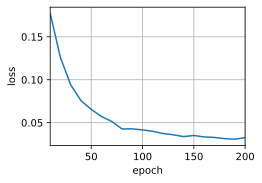

In [40]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs = 0.005, 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

#X, X_valid_len, Y, Y_valid_len
# X和Y带上批量，形状是：(b,num_steps)
# X_valid_len和Y_valid_len是长度，形状是(b,)
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

### 预测

In [41]:
import collections
import math

def predict_seq2seq(net, 
                    src_sentence,      #源序列
                    src_vocab,         #源文本Vocab类
                    tgt_vocab,         #目标文本Vocab类
                    num_steps,         #序列长度
                    device, 
                    save_attention_weights=False
                    ):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    #单词级别token，以空格划分，在后面加一个eos的token
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]

    #这里有的奇怪，为什么？？
    # enc_valid_len = torch.tensor([len(src_tokens)], device=device)

    #截断和填充
    src_tokens = torch.tensor(truncate_pad(src_tokens, num_steps, src_vocab['<pad>']),dtype=torch.long, device=device)
    
    enc_valid_len = (src_tokens != src_vocab['<pad>']).type(torch.int32).sum().unsqueeze(dim=0)

    # 添加批量轴
    enc_X = torch.unsqueeze( src_tokens, dim=0)

    enc_outputs = net.encoder(enc_X, enc_valid_len)
    
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        #每一次输入的是一个token
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

#机器翻译评估标准
#pred_seq：文本序列，str类型
#label_seq：文本序列strl类型
def bleu(pred_seq, label_seq, k):  
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j’ai fait signe .,  bleu 0.000
he's calm . => il est calmes .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


### 可视化注意力权重

In [42]:
from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt

def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices.

    Defined in :numref:`sec_queries-keys-values`"""
    backend_inline.set_matplotlib_formats('svg')
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

#### 编码器的注意力权重可视化

 形状：(num_layers, num_heads, num_steps, num_steps)

torch.Size([2, 4, 10, 10])


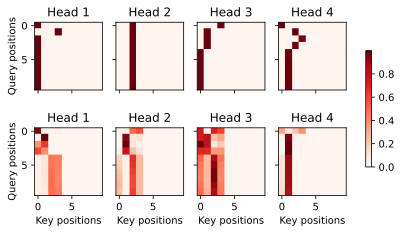

In [43]:
#net.encoder.attention_weights:[层1,...,层n]
#每一层：注意力权重：(batch*num_heads, num_steps, num_steps)(1*4,10,32/4)
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
# 形状：(num_layers, num_heads, num_steps, num_steps)
print(enc_attention_weights.shape)

show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

#### 解码器的注意力权重可视化
1. 掩码自注意力
2. 编码器-解码器之间的注意力机制

In [44]:
#dec_attention_weight_seq
# [net.decoder.attention_weights]
#三层list：分别是num_steps,mark_or_att,num_layers

dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

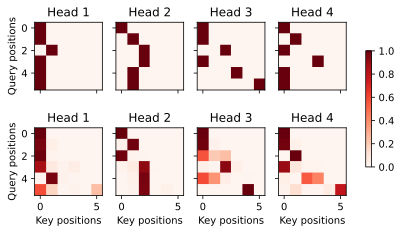

In [45]:
# Plusonetoincludethebeginning-of-sequencetoken
show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

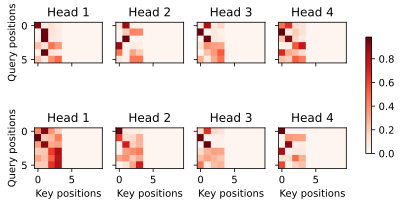

In [46]:
show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))